1. Use python libraries to build a decision tree classifier on Dataset 1. Analyze the results using confusion matrix and accuracy. Plot the Decision Tree

In [ ]:
import numpy as np
import pandas as pd

Get the data

In [ ]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv",skiprows=1, header=None, names=col_names)
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Node classes

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

Tree Class

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)

        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):


        best_split = {}
        max_info_gain = -float("inf")


        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:

                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")

                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain


        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy '''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

Train Test Split

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

Fit the Model

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 1.9 ? 0.9264046681474138
 left:setosa
 right:X_3 <= 1.5 ? 0.7694993941591152
  left:X_2 <= 4.9 ? 0.17556502585750278
    left:versicolor
    right:virginica
  right:X_2 <= 5.0 ? 0.1228956258058704
    left:X_1 <= 2.8 ? 0.46691718668869925
        left:virginica
        right:versicolor
    right:virginica


Test the Model

In [ ]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

In [ ]:

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

Read Data

In [ ]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
pima = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)
pima.head(5)

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Train Test Split

In [ ]:

feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = pima[feature_cols]
y = pima.type

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Fit and predit

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
clf = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

Performance Evaluation

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


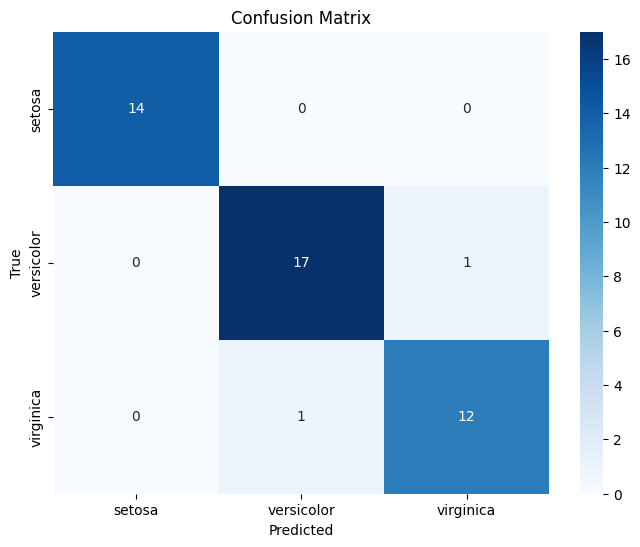

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pima['type'].unique(), yticklabels=pima['type'].unique())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()



##Visualization

In [ ]:
pip install graphviz

In [ ]:
pip install pydotplus

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

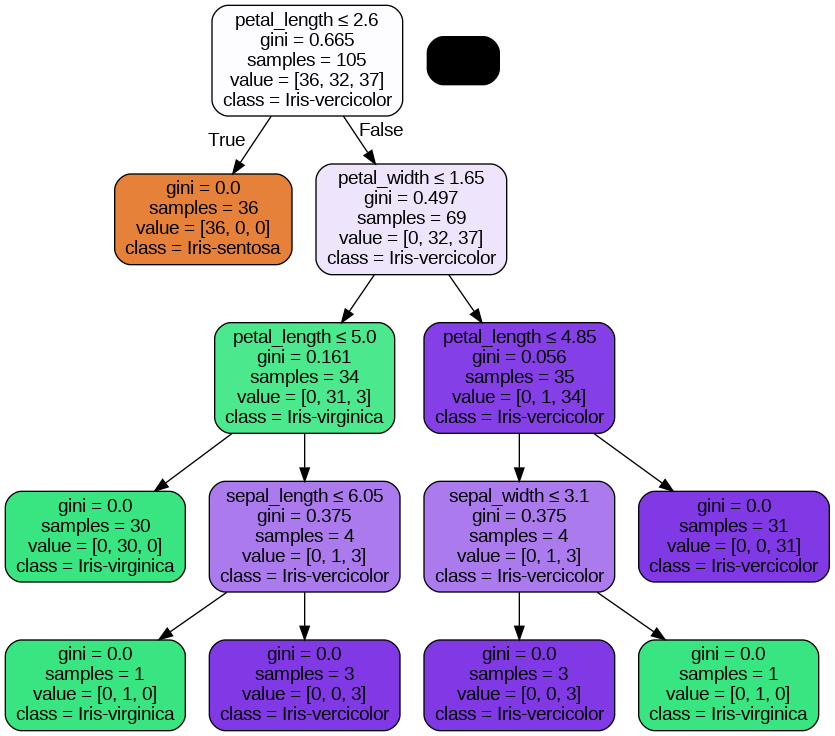

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Iris-sentosa','Iris-virginica', 'Iris-vercicolor'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('iris.png')
Image(graph.create_png())

In [ ]:
clf = DecisionTreeClassifier(criterion="entropy", splitter="random", max_depth=3)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8888888888888888


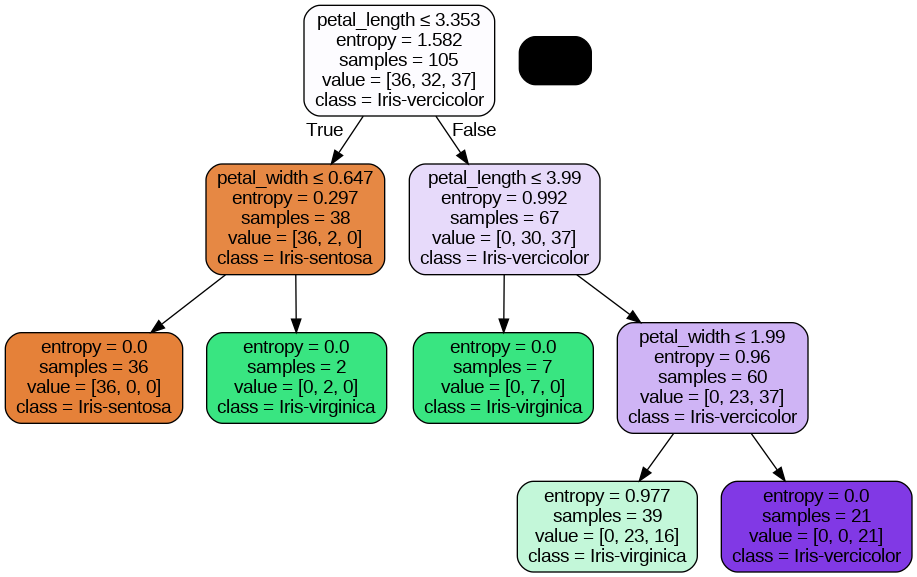

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Iris-sentosa','Iris-virginica', 'Iris-vercicolor'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('iris.png')
Image(graph.create_png())

2. Write a code to show overfitting in the decision tree classifier built using Dataset 1. Use sklearn and matplotlib.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)

print(X.shape, y.shape)

(10000, 20) (10000,)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_scores, test_scores = list(), list()

values = [i for i in range(1, 21)]

In [ ]:

for i in values:
	model = DecisionTreeClassifier(max_depth=i)

	model.fit(X_train, y_train)

	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)

	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.771, test: 0.754
>2, train: 0.809, test: 0.814
>3, train: 0.880, test: 0.885
>4, train: 0.901, test: 0.898
>5, train: 0.910, test: 0.902
>6, train: 0.920, test: 0.908
>7, train: 0.939, test: 0.924
>8, train: 0.947, test: 0.924
>9, train: 0.956, test: 0.923
>10, train: 0.963, test: 0.925
>11, train: 0.973, test: 0.931
>12, train: 0.980, test: 0.926
>13, train: 0.985, test: 0.925
>14, train: 0.989, test: 0.917
>15, train: 0.993, test: 0.921
>16, train: 0.997, test: 0.914
>17, train: 0.998, test: 0.917
>18, train: 1.000, test: 0.915
>19, train: 1.000, test: 0.914
>20, train: 1.000, test: 0.916


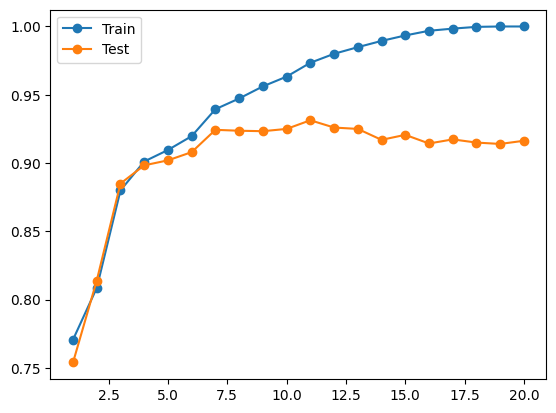

In [ ]:
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [ ]:

from sklearn.tree import DecisionTreeClassifier
deep_tree = DecisionTreeClassifier(max_depth=None)
deep_tree.fit(X_train, y_train)
print("Deep Tree Accuracy:", deep_tree.score(X_test, y_test))

pruned_tree = DecisionTreeClassifier(max_depth=3)
pruned_tree.fit(X_train, y_train)
print("Pruned Tree Accuracy:", pruned_tree.score(X_test, y_test))


Deep Tree Accuracy: 0.9173333333333333
Pruned Tree Accuracy: 0.885


3. Implement Decision tree regressor on Dataset 2.


In [ ]:
df = pd.read_csv("data.csv")
print(df.columns)


Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


MAE: 8495.966239509191
RMSE: 18655.36340215665
R² Score: 0.8539910358075516


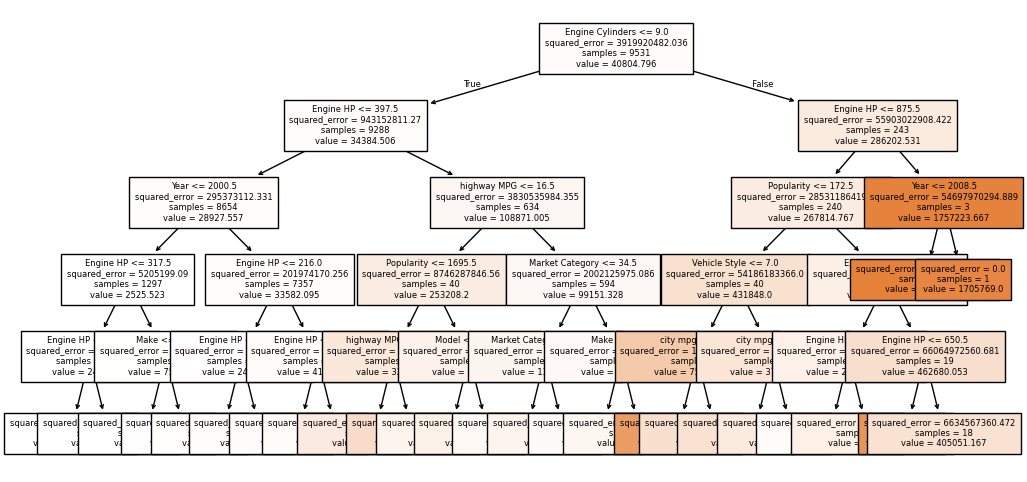

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df.columns = df.columns.str.strip()
X, y = df.drop(columns=['MSRP']), df['MSRP']
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R² Score: {r2_score(y_test, y_pred)}")


plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X.columns, filled=True, fontsize=6)
plt.show()
